Double elastic pendulum! Elastic-ness serves as a soft-constraint, so no need for hard-constraint integration

Imports

In [36]:
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

import aqua_blue

Define simulation class that performs integration

In [3]:
def normalize(x: np.typing.NDArray) -> np.typing.NDArray:

    return x / np.linalg.norm(x)


@dataclass
class DoublePendulum:

    acceleration_from_gravity: float
    spring_constant: float
    mass: float
    length: float
    anchor: np.typing.NDArray
    positions: Tuple[np.typing.NDArray, np.typing.NDArray]
    velocities: Tuple[np.typing.NDArray, np.typing.NDArray]

    def __post_init__(self):

        if not isinstance(self.anchor, np.ndarray):
            self.anchor = np.array(self.anchor)

        if not isinstance(self.positions, np.ndarray):
            self.positions = np.array(self.positions)

        if not isinstance(self.velocities, np.ndarray):
            self.velocities = np.array(self.velocities)

    @property
    def gravity(self) -> float:

        return np.array([0, self.mass * self.acceleration_from_gravity])

    @property
    def potential_energy(self) -> float:

        return self.acceleration_from_gravity * self.mass * (self.positions[0][1] + self.positions[1][1]) + \
               0.5 * self.spring_constant * (
                       (np.linalg.norm(self.positions[0] - self.anchor) - self.length) ** 2 +
                       (np.linalg.norm(self.positions[1] - self.positions[0]) - self.length) ** 2
               )

    @property
    def kinetic_energy(self) -> float:

        return 0.5 * self.mass * (np.linalg.norm(self.velocities[0]) ** 2 + np.linalg.norm(self.velocities[1]) ** 2)

    def step(self, timestep: float):

        r1, r2 = self.positions
        v1, v2 = self.velocities

        f1 = self.spring_constant * (np.linalg.norm(self.anchor - r1) - self.length) * normalize(self.anchor - r1) + \
            self.spring_constant * (np.linalg.norm(r2 - r1) - self.length) * normalize(r2 - r1) - self.gravity
        f2 = self.spring_constant * (np.linalg.norm(r1 - r2) - self.length) * normalize(r1 - r2) - self.gravity

        # Velocity Verlet: half-step velocity
        v1_half = v1 + 0.5 * timestep * f1
        v2_half = v2 + 0.5 * timestep * f2

        # Position update
        r1 += timestep * v1_half
        r2 += timestep * v2_half

        # New forces
        f1_new = self.spring_constant * (np.linalg.norm(self.anchor - r1) - self.length) * normalize(self.anchor - r1) + \
                self.spring_constant * (np.linalg.norm(r2 - r1) - self.length) * normalize(r2 - r1) - self.gravity
        f2_new = self.spring_constant * (np.linalg.norm(r1 - r2) - self.length) * normalize(r1 - r2) - self.gravity

        # Final velocity update
        v1 = v1_half + 0.5 * timestep * f1_new / self.mass
        v2 = v2_half + 0.5 * timestep * f2_new / self.mass

        self.positions = (r1, r2)
        self.velocities = (v1, v2)

Example run

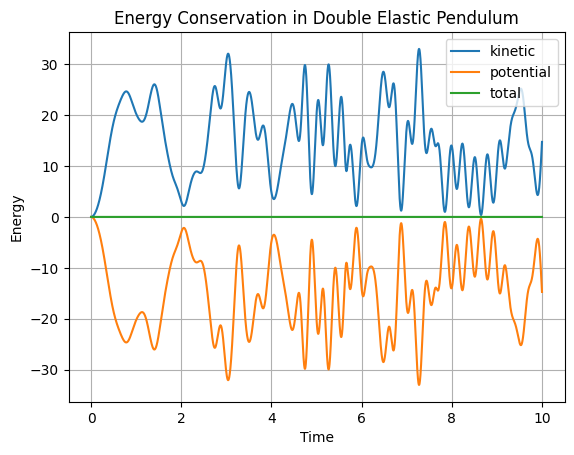

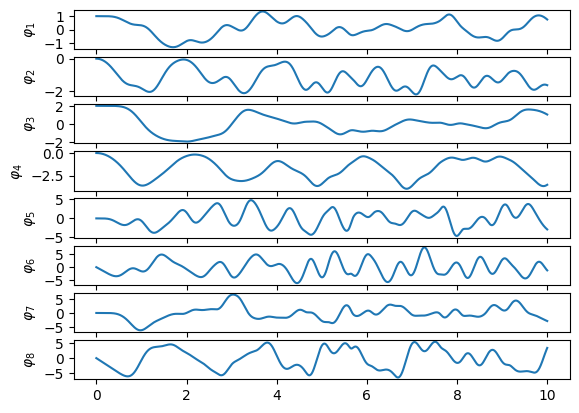

In [40]:
double_pendulum = DoublePendulum(
    acceleration_from_gravity=9.81,
    spring_constant=50.0,
    length=1.0,
    mass=1.0,
    anchor=(0.0, 0.0),
    positions=[
        [1.0, 0.0],
        [2.0, 0.0],
    ],
    velocities=[
        [0.0, 0.0],
        [0.0, 0.0]
    ]
)

KE_history = []
PE_history = []

steps = 10000
timestep = 1.0e-3
phase_space_trajectory = np.zeros((steps, 8))
ke_history = np.zeros(steps)
pe_history = np.zeros(steps)
for i in range(steps):

    phase_space_trajectory[i] = np.concat((*double_pendulum.positions, *double_pendulum.velocities))
    ke_history[i] = double_pendulum.kinetic_energy
    pe_history[i] = double_pendulum.potential_energy

    double_pendulum.step(timestep=timestep)

# Plot energy over time
t = np.linspace(0, timestep * steps, steps)
plt.plot(t, ke_history, label="kinetic")
plt.plot(t, pe_history, label="potential")
plt.plot(t, ke_history + pe_history, label="total")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Conservation in Double Elastic Pendulum')
plt.grid()
plt.show()
plt.close()

fig, axs = plt.subplots(nrows=8, sharex=True)
for i, (ax, dim) in enumerate(zip(axs, phase_space_trajectory.T)):
    ax.plot(t, dim)
    ax.set_ylabel(rf"$\varphi_{{{i + 1}}}$")

In [192]:
time_series = aqua_blue.time_series.TimeSeries(dependent_variable=phase_space_trajectory, times=t)

normalizer = aqua_blue.utilities.Normalizer()
time_series_normalized = normalizer.normalize(time_series)

model = aqua_blue.models.Model(
    reservoir=aqua_blue.reservoirs.DynamicalReservoir(
        reservoir_dimensionality=2000,
        input_dimensionality=8,
        sparsity=0.95,
        spectral_radius=1.1,
        leaking_rate=0.9
    ),
    readout=aqua_blue.readouts.LinearReadout()
)
model.train(time_series_normalized)

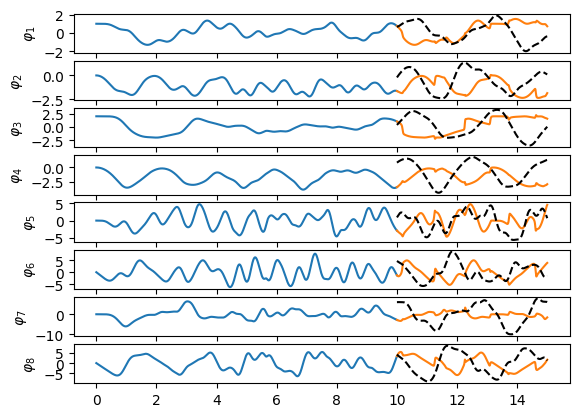

In [193]:
horizon = 5_000
prediction = model.predict(horizon=horizon)
prediction = normalizer.denormalize(prediction)

actual = np.zeros((horizon, model.reservoir.input_dimensionality))
for i in range(horizon):
    double_pendulum.step(timestep=timestep)
    actual[i, :] = np.concat((*double_pendulum.positions, *double_pendulum.velocities))

fig, axs = plt.subplots(nrows=model.reservoir.input_dimensionality, sharex=True)
for i, (ax, dim) in enumerate(zip(axs, prediction.dependent_variable.T)):
    ax.plot(t, phase_space_trajectory[:, i])
    ax.plot(prediction.times, dim)
    ax.plot(prediction.times, actual[:, i], color="black", linestyle="--")
    ax.set_ylabel(rf"$\varphi_{{{i + 1}}}$")